In [15]:
##############################
#
#    PARAMETERS 
#
##############################


import math

# What data to use
tableBase = '4PpKk'
convertStates = False
fractionOfDataToUse = 1 # [0,1]

# Transfer Learning
loadWeights = False 
weightsSource = '012'

# Save results
saveResults = True

# Compare with other result during training
compareResultsDuringTraining = True
compareWith = '005' # orginal net structure, trained from random on 4pc dataset


# NN parameters
useBatchNorm = False
filters = [8,16,32,64,128]
filterShape = [2,2,2,2,2]
batch_size = 4096
epochs = 500
multiGPU = False
whichGPU = 0
# optimizer = 'Adam'
optimizer = 'Adadelta'



### NO NEED TO MODIFY BELOW ###
# Generate dataset variables
fileName = tableBase + '.hdf5'
dataSetName = tableBase + '_onlyLegal'
if not convertStates: 
    dataSetName = tableBase + '_onlyLegal_fullState'
dataSetWdlName = tableBase + '_Wdl_onlyLegal'

# Number of Pieces
nPi =  int(dataSetName[0])
nPa = nPi - 2
nWPa = math.ceil(nPa/2)

# Other NN stuff
num_classes = 5
input_shape = (4,8,8)

##############################
#
#    IMPORTS 
#
##############################

# ### To select which GPU to use, import these before importing Keras or Tensorflow
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# # The GPU id to use, usually either &quot;0&quot; or &quot;1&quot;
# os.environ["CUDA_VISIBLE_DEVICES"]="0"  
 
# # Do other imports now...

import os
    
if(multiGPU):
    from keras.utils.training_utils import multi_gpu_model
else:
    import os
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    # The GPU id to use, usually either "0" or "1"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(whichGPU)

from matplotlib import pyplot as plt
from IPython.display import clear_output

# from __future__ import print_function
import keras
# from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras import backend as K
# import pandas as pd
from sklearn.model_selection import train_test_split
import sys
import h5py
import numpy as np
import pickle

##############################
#
#    Misc Functions
#
##############################

def createDir(dir):
    if os.path.exists(dir):
        print("Error, directory " + str(dir) + " already exists, abort mission.")
        sys.exit()
    else:
        os.makedirs(dir)
        
def save_obj(saveDir, saveName, obj ):
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)
    with open(saveDir + '/' + saveName + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(dir, fileName ):
    with open(dir + '/' + fileName + '.pkl', 'rb') as f:
        return pickle.load(f)
    
# compareResultsDuringTraining = True
# compareWith = '005'

class PlotLosses(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        # Reshape input vector to fit on graph
        def reshapeVector(vec):
            l = len(vec)
            L = epochs - l
            if L>=0:
                tail = np.ones((L), dtype = int) * vec[-1]
                vec = np.hstack((vec,tail))
            return vec
                
        
        # Load data to compare with 
        if compareResultsDuringTraining:
            self.compareData = load_obj('Results/' + compareWith, 'fitHistory')
            self.compAcc = reshapeVector(self.compareData['acc'])
            self.compValAcc = reshapeVector(self.compareData['val_acc'])
            self.compLoss = reshapeVector(self.compareData['loss'])
            self.compValLoss = reshapeVector(self.compareData['val_loss'])
        
        self.i = 0
        self.x = []
        self.loss = []
        self.val_loss = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
#         self.logs = {'acc':[], 'val_acc':[], 'loss':[], 'val_loss':[]}

    def on_epoch_end(self, epoch, logs={}):
        if self.i == 70:
            model.save_weights('fitTemp/weights_70epochs.hdf5')
        
        self.x.append(self.i)
        self.loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.acc.append(logs['acc'])
        self.val_acc.append(logs['val_acc'])
        self.logs = {'acc':self.acc, 'val_acc':self.val_acc, 'loss':self.loss, 'val_loss':self.val_loss}
        self.i += 1
        print("1 self.logs", self.logs)
        
        clear_output(wait=True)
    
        # Create plots
        f = plt.figure(figsize=(15,7))
        ax = f.add_subplot(121)
        ax2 = f.add_subplot(122)
        
        # Plot Loss 
        ax.plot(self.x, self.loss, color='blue', label="Train", linewidth = 1)
        ax.plot(self.x, self.val_loss, color='deepskyblue', label="Validation", linewidth = 1)
        ax.plot(self.x, self.compLoss[:len(self.loss)], color='black', label=compareWith + " Training", linewidth = 1)
        ax.plot(self.x, self.compValLoss[:len(self.loss)], color='gray', label=compareWith + " Validation", linewidth = 1)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.set_ylim(bottom=0)
        ax.grid(True)
        
#         # Plot Accuracy
        ax2.plot(self.x, self.acc, 'b-', label="Train", linewidth = 1)
        ax2.plot(self.x, self.val_acc, color = 'deepskyblue', label="Validation", linewidth = 1)
        ax2.plot(self.x, self.compAcc[:len(self.acc)], color='black', label=compareWith + " Training", linewidth = 1)
        ax2.plot(self.x, self.compValAcc[:len(self.acc)], color='silver', label=compareWith + " Validation", linewidth = 1)
        ax.set
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracty')
        ax2.legend()
        ax2.set_ylim(top=1)
        ax2.grid(True)
        
        # Show and save plot
# #         plt.tight_layout()
        plt.savefig('fitTemp/currentAccAndLoss')
        plt.show();

#         # Plot Loss
#         plt.subplot(1,2,1)
#         plt.figure(figsize=(8,8))
#         plt.plot(self.x, self.loss, 'b-', label="Train", linewidth = 1)
#         plt.plot(self.x, self.val_loss, 'r-', label="Validation", linewidth = 1)
#         plt.plot(self.x, self.compLoss[:len(self.loss)], 'b--', label=compareWith + " Training")
#         plt.plot(self.x, self.compValLoss[:len(self.loss)], 'r--', label=compareWith + " Validation")
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
#         plt.legend()
#         plt.ylim(bottom=0)
#         plt.grid(True)
# #         plt.savefig('fitTemp/currentLoss')
# #         plt.show();
        
#         # Plot Accuracy
#         plt.subplot(1,2,2)
#         plt.figure(figsize=(8,8))
#         plt.plot(self.x, self.acc, 'b-', label="Train", linewidth = 1)
#         plt.plot(self.x, self.val_acc, 'r-', label="Validation", linewidth = 1)
#         plt.plot(self.x, self.compAcc[:len(self.acc)], 'b--', label=compareWith + " Training")
#         plt.plot(self.x, self.compValAcc[:len(self.acc)], 'r--', label=compareWith + " Validation")
#         plt.xlabel('Epochs')
#         plt.ylabel('Accuracty')
#         plt.legend()
#         plt.ylim(top=1)
#         plt.grid(True)
        
#         # Show and save plot
# #         plt.tight_layout()
# #         plt.savefig('fitTemp/currentAccAndLoss')
#         plt.show();
        
        print("Train Accuracy of last epoch: ", logs['acc'])
        print("Validation Accuracy of last epoch: ", logs['val_acc'])
        print("Train Loss of last epoch: ", logs['loss'])
        print("Validation Loss of last epoch: ", logs['val_loss'])
        
        with open('fitTemp/logs.txt','w') as file:
            file.write(str(self.logs))
            
        with open('fitTemp/atEpochNr.txt','w') as file:
            file.write(str(epoch))
        
plot_losses = PlotLosses()

def sq2hnit(sq):
    col = sq%8
    row = (sq - col)//8
    return col,row

# 0: pawns
# 1: kings
def vecSt2fullSt(vecSt, nPi, nPa, nWPa):
    fullSt = np.zeros((4,8,8), dtype = 'bool')
    for i in range(nPi - 2):
        sq = vecSt[i]
        col,row = sq2hnit(sq)
        if i < nWPa:
            fullSt[0][row][col] = True
        else:
            fullSt[1][row][col] = True
    col,row = sq2hnit(vecSt[-2])
    fullSt[2][row][col] = True
    col,row = sq2hnit(vecSt[-1])
    fullSt[3][row][col] = True
    return fullSt 

def vecSt2fullSt_8x8x2(vecSt, nPi, nPa, nWPa):
    fullSt = np.zeros((8,8,2), dtype = 'int8')
    for i in range(nPi - 2):
        sq = vecSt[i]
        col,row = sq2hnit(sq)
        if i < nWPa:
            fullSt[row][col][0] = 1
        else:
            fullSt[row][col][0] = -1
    col,row = sq2hnit(vecSt[-2])
    fullSt[row][col][1] = 1
    col,row = sq2hnit(vecSt[-1])
    fullSt[row][col][1] = -1
    return fullSt 

# count nr of each score instance
# wdlCounter placeholders: [-2, -1, 0, 1 ,2]

def wdlCountingMachine(ds):
    wdlCounter = [0,0,0,0,0]
    l = len(ds)
    i = 0
    intv = l//100
    for wdl in ds:
        i += 1
        if i%intv == 0:
            sys.stdout.write(str((i*100)//l) + " percentage")
            sys.stdout.write('\r')
            sys.stdout.flush()
        wdlCounter[wdl[0] + 2] += 1
    print(wdlCounter)
    return wdlCounter
# wdlCountingMachine(d3t)

##############################
#
#    LOAD DATA
#
##############################
# load datasets
def loadData():
    with h5py.File(fileName, 'r') as f:
        d = f[dataSetName]
        dt = f[dataSetWdlName]
        l = len(d)
        loadLength = int(l * fractionOfDataToUse)

        if convertStates:
            X = np.array([vecSt2fullSt(vecSt,nPi, nPa, nWPa) for vecSt in d[:loadLength]])
        else:
            X = d[:loadLength]

        y = dt[:loadLength]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    del X
    del y

    print('X_train shape:', X_train.shape)
    print('y_train shape:', y_train.shape)
    print('X_test shape:', X_test.shape)
    print('y_test shape:', y_test.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')


    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return X_train, X_test, y_train, y_test

#X_train, X_test, y_train, y_test = loadData()

##############################
#
#    CREATE MODEL
#
##############################
def createModel(filters, filterShape):
    # import keras.backend as K
    # K.set_floatx('float16')
    # K.set_epsilon(1e-4) #default is 1e-7
    # K.set_floatx('float32')
    # K.set_epsilon(1e-7) #default is 1e-7

    model = Sequential()


    nnStr = ''
    for i in range(len(filters)):
        s = str(filterShape[i])
        filter = str(filters[i])
        nnStr += s + 'x' + filter + '-'
    nnStr = nnStr[:-1]

    assert (len(filters) == len(filterShape)),"Error, len(filters) != len(filterShape)"
    if useBatchNorm:
        for i in range(len(filters)):
            if i  == 0:
                model.add(Conv2D(filters[i], kernel_size=(filterShape[i], filterShape[i]),
                                 padding='valid',
                                 data_format = "channels_first",
                                 use_bias = False,
                #                  kernel_initializer = 
                                 input_shape=input_shape))
            else:
                model.add(Conv2D(filters[i], kernel_size=(filterShape[i], filterShape[i]),
                                 use_bias = False,
                                 padding='valid'))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
    else:
        for i in range(len(filters)):
            if i  == 0:
                model.add(Conv2D(filters[i], kernel_size=(filterShape[i], filterShape[i]),
                                 padding='valid',
                                 activation='relu',
                                 data_format = "channels_first",
    #                              kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None),
                                 input_shape=input_shape))
            else:
                model.add(Conv2D(filters[i], kernel_size=(filterShape[i], filterShape[i]),
                                 padding='valid',
    #                              kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None),
                                 activation='relu'))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    if multiGPU: 
        model = keras.utils.multi_gpu_model(model, gpus=2)
    model.summary()
    
    if loadWeights:
        model.load_weights('Results/' + weightsSource + '/weights.hdf5')


    if optimizer == "Adadelta":
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])
    elif optimizer == 'Adam':
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
                      metrics=['accuracy'])
    else:
        sys.exit("Error, invalid optimizer.")
    return model, nnStr

#filters = [8,32,64,128,256]
#filterShape = [2,2,2,2,2]
#model = createModel(filters, filterShape)

##############################
#
#    TRAIN MODEL
#
##############################
def trainModel():
    fitHistory = model.fit(X_train, y_train,
          batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              callbacks=[plot_losses],
              validation_data=(X_test, y_test))
    return fitHistory
#fitHistory = trainModel()

##############################
#
#    CALCULATE SCORE
#
##############################
def calcScore():
    score = model.evaluate(X_test, y_test, verbose=1)
    print('Evaluated test loss:', score[0])
    print('Evaluated test accuracy:', score[1])
    return score
#score = calcScore()

##############################
#
#    SAVE RESULTS
#
##############################
def saveTrainResults():
    #Get next fitID
    with open('Results/lastFitId.txt','r') as file:
        lastId = file.read()
    fitId = str(int(lastId) + 1).zfill(3)
    fitId = fitId
    with open('Results/lastFitId.txt','w') as file:
        file.write(fitId)

    # Generate save dir
    saveDir = 'Results/' + str(fitId)
    print('Save dir: ' + saveDir)
    print("Creating save dir")
    if os.path.exists(saveDir):
        print("Save dir already exists, aborting!!!")
        sys.exit("Save dir already exists, aborting!!!")

    # Save info directories
    ep = len(model.history.history['acc'])
    if loadWeights:
        initWeightsId = weightsSource
    else:
        initWeightsId = 'RND'
    createDir(saveDir + '/_' +  '1.numberOfPieces-------' + str(nPi)) 
    createDir(saveDir + '/_' +  '2.neuralNetStructure---' + str(nnStr) )
    createDir(saveDir + '/_' +  '3.loadedWeightsFrom----' +  str(initWeightsId) )
    createDir(saveDir + '/_' +  '4.epochs---------------' +  str(ep) + '_of_' + str(epochs) )
    createDir(saveDir + '/_' +  '5.batchSize------------' +  str(batch_size) )
    createDir(saveDir + '/_' +  '6.optimizer------------' +  str(optimizer) )
    createDir(saveDir + '/_' +  '7.finalAccuracy--------' +  str(round(score[1],3)))

    #save history
    print("Saving history...")
    hist = model.history.history
    saveName = 'fitHistory'
    save_obj(saveDir, saveName, hist)

    #save weights
    print("Saving weights...")
    model.save_weights(saveDir + '/' + 'weights.hdf5')

    #save figures
    print("Saving figures...")
    acc = hist['acc']
    loss = hist['loss']
    val_acc = hist['val_acc']
    val_loss = hist['val_loss']
    x = [i for i in range(len(acc))]

    # Create plots
    f = plt.figure(figsize=(15,7))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    # Plot Loss 
    ax.plot(x, loss, color='blue', label="Train", linewidth = 1)
    ax.plot(x, val_loss, color='deepskyblue', label="Validation", linewidth = 1)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.set_ylim(bottom=0)
    ax.grid(True)

    # Plot Accuracy
    ax2.plot(x, acc, 'b-', label="Train", linewidth = 1)
    ax2.plot(x, val_acc, color = 'deepskyblue', label="Validation", linewidth = 1)
    ax.set
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracty')
    ax2.legend()
    ax2.set_ylim(top=1)
    ax2.grid(True)

    # Save plots
    plt.savefig(saveDir + '/performance')
    plt.show();

    #save summary
    print("Saving summary...")
    from contextlib import redirect_stdout

    with open(saveDir + '/modelsummary.txt', 'w') as f:
        with redirect_stdout(f):
            model.summary()
    print("All done!")
#saveTrainResults()

##############################
#
#    COMPARE RESULTS
#
##############################
def compareResults(res1, res2, label1 = '', label2 = '', metric1 = 'acc', metric2 = 'acc', saveFigName = '', makeEqual = False):
    # Reshape input vector to fit on graph
    def makeEqualLength(vec1, vec2):
        l1 = len(vec1)
        l2 = len(vec2)
        if l1 == l2:
             pass
        elif l1 > l2: 
            l = l1 - l2
            tail = np.ones((l), dtype = int) * vec2[-1]
            vec2 = np.hstack((vec2,tail))
        else:
            l = l2 - l1
            tail = np.ones((l), dtype = int) * vec1[-1]
            vec1 = np.hstack((vec1,tail))
        return vec1, vec2
     
    y1 = load_obj('Results/' + res1,'fitHistory')
    y2 = load_obj('Results/' + res2,'fitHistory')
    acc1 = y1[metric1]
    acc2 = y2[metric2]
    
    if makeEqual:
        acc1, acc2 = makeEqualLength(acc1, acc2)
    
    if label1 == '' :
        label1 = res1
    if label2 == '' :
        label2 = res2
        
    bottom, top = plt.ylim()  # return the current ylim
    if "acc" in metric1:
        print('plotting accuracy')
        yname = "Accuracy"
        plt.ylim(bottom = bottom, top=1)
    else:
        print('plotting loss')
        plt.ylim(bottom = 0, top=top)
        yname = "Loss"
    
    x = [i for i in range(len(acc1))]
    plt.plot(x,acc1, label = label1)
    x = [i for i in range(len(acc2))]
    plt.plot(x,acc2, label = label2)
    bottom, top = plt.ylim()  # return the current ylim
    if "acc" in metric1:
        print('plotting accuracy')
        yname = "Accuracy"
        plt.ylim(bottom = bottom, top=1)
    else:
        print('plotting loss')
        plt.ylim(bottom = 0, top=top)
        yname = "Loss"
    plt.xlabel('epochs')
    plt.ylabel(yname)
    plt.legend()
    if saveFigName != '': plt.savefig(saveFigName)
    plt.show()

#compareResults('005','011', label1='test1', label2='test2', metric1='loss', metric2='loss', saveFigName = 'testmynd', makeEqual = True)

### Experiments
    - Test if small batch is better
        - Exp 1
            - Save to 006
            - starting from 005, and shring batch size to 512
            - Results: after 183 epochs, the accuracy was actually lower than before training. 
              Batch size is probably not to big at 4096.
        - Exp 2
            - Starting from 012, a 100.000 pm net trained for 1600 epochs at bs 4096
            - Switching to bs 32 created horrible results, network totally failed to perform, lost acc from 
              0.95 to 0.85 in 17 epochs. Plus, super slow to train
    - Test Adam
        - Results
            - 007 Adam, final accuracy 0.939 after 500
            - 005 Adadelta, final accuracy 0.952 after 1000 epochs
            - Adam not performing better than Adadelta
    - Test 2x2 and 3x3 filters for performance
        - 2x2 5 layers (005)
        - 3x3 3 layers (003)
        - ~50.000 parameters
        - Results
            - 005 vs 008
            - Same performance after 331 epochs
    - Test float16
        - 005 float32
        - 010 float16
        - Results
            - float16 scored lower
            - float16 is 40% longer per epoch (35sec vs 50sec per epoch
            - float32 is the way to go!
    - Try Batch Normalization
        - model.add(BatchNormalization())
        - Results:
            - Comparing with 005, no batch norm
            - Saved to 011, with batch norm
            - ~same number of weights...
            - Batch Normalization is performing worse after ~40 epochs
    - Try different initial weights
        - keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
        - Results
            - Tried for a few epochs, similar curve as for 005
    - Test different size model
        - Experiments
            - 005
                - 50kpm
                - 500 epochs
                - 0.952 acc
                - still learning
                - 2048bs > 37s/epoch
                - 4096bs > 29s/epoch
            - 013
                - 188kpm
                - 350 epochs
                - 0.968 acc
                - 150-200 epochs > stalled
                - 0.968 after 350 epochs
                - 6 hours
            - 014
                - 388kpm
                - epochs
                - 0.974 after 243 epochs
            - xxx not saved
                - 500kpm
                - 143 epochs
                - 0.972
                - slightly worse performance than 014, possibly slower to converge, but taking to long to train
            - 016
                - 10kpm
                - 500 epochs
                - 0.91 acc
            - 01
                - 
        - Results
            - 014 is best, 005 probably good enough
            - 017 is best for fast training, maybe?
    - Measure kpm and batch size effect on calc speed
        - not much difference
            - #016:0.913  10kpm 2048:30                  8192:23:38% 32768:17:52% 
            - #005:0.952  50kpm 2048:37s    4096:28:50% 
            - #013:0.968 188kpm 2048:50s    4096:40s:61%             32768:46s:80% 65536:42s:99% 
            - #014:0.974 388kpm 2048:3m:91% 
    - Test effect of bigger batch size
        - Faster calculations, but much worse performance
            - see 017 and 018
    - Try smaller batch size
        - source 014
            - 2048 batch size
        - dest
            - 256 bs
        -Results
            - started to forget, 
            





    - Do tree fold testing on 014, and focus on lággildi in loss at 50epochs
    
    - early stopping and tensorboard
        - https://keras.io/callbacks/
        - https://stackoverflow.com/questions/43906048/keras-early-stopping
    - Transfer learning
        - Read article again
        - Make function for measurements
            - Copy on n first layers
            - freeze layers
            - Average
           



    - Test Checkpoints feature
    - Three fold splitting
        - model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10)
        - https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
    - cross validation
        - https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
    - Train longer....

    - Try opther optimizers

    - Make histogram of WDL values
    - Do TL experiment
        - Take into account data split effect on TL (split 4pc at x, and then transfer to 5pc)
        - Three split data, training, validation and testing
        - Results
    - Finish 5pc dataset



# WDL score count
#### 3PKk-WDL-Seq
[0, 0, 125024, 0, 124960]

### Try 388.000 weights and larger batch size


In [32]:
import math

# What data to use
tableBase = '4PpKk'
convertStates = False
fractionOfDataToUse = 1 # [0,1]

# Transfer Learning
loadWeights = False 
weightsSource = '014'

# Compare with other result during training
compareResultsDuringTraining = True
compareWith = '014' # orginal net structure, trained from random on 4pc dataset


# NN parameters
filters = [8,16,16,32,32]
filterShape = [2,2,2,2,2]
batch_size = 2048
epochs = 500 

In [34]:
model, nnStr = createModel(filters, filterShape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 8, 7, 7)           136       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 7, 6, 16)          464       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 6, 5, 16)          1040      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 5, 4, 32)          2080      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 4, 3, 32)          4128      
_________________________________________________________________
flatten_8 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 1925      
Total para

In [11]:
X_train, X_test, y_train, y_test = loadData()

X_train shape: (4982178, 4, 8, 8)
y_train shape: (4982178, 1)
X_test shape: (2453910, 4, 8, 8)
y_test shape: (2453910, 1)
4982178 train samples
2453910 test samples


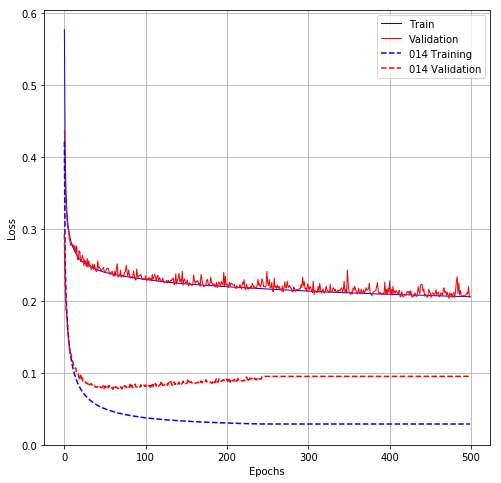

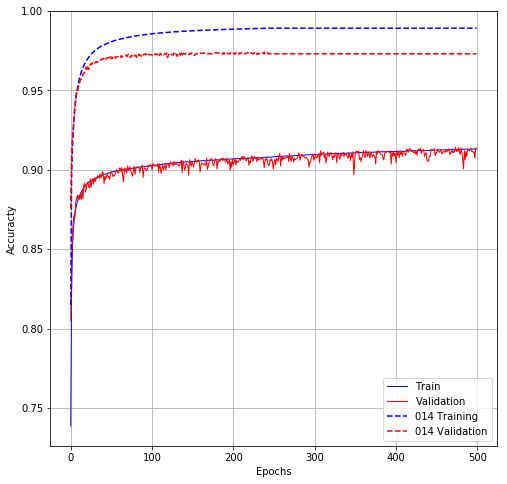

Train Accuracy of last epoch:  0.9132634361900006
Validation Accuracy of last epoch:  0.9132759555161825
Train Loss of last epoch:  0.2058645549700714
Validation Loss of last epoch:  0.20561510685398238


In [35]:
fitHistory = trainModel()

In [36]:
score = calcScore()

2453910/2453910 [==============================] - 110s 45us/step
Evaluated test loss: 0.20561510585653955
Evaluated test accuracy: 0.9132759555157453


Save dir: Results/016
Creating save dir
Saving history...
Saving weights...
Saving figures...


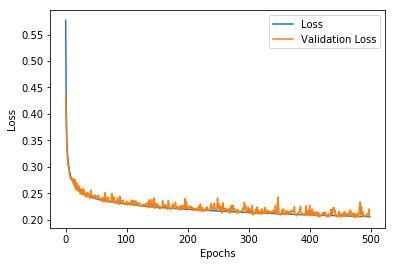

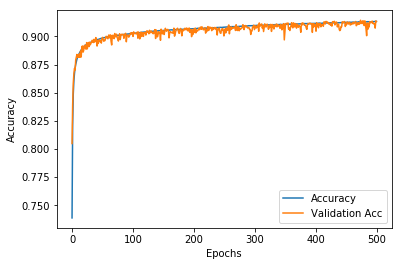

Saving summary...
All done!


In [37]:
saveTrainResults()

plotting accuracy
plotting accuracy


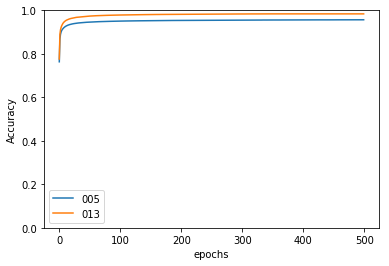

plotting accuracy
plotting accuracy


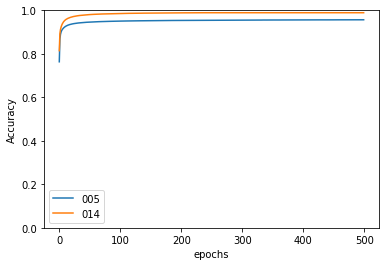

plotting accuracy
plotting accuracy


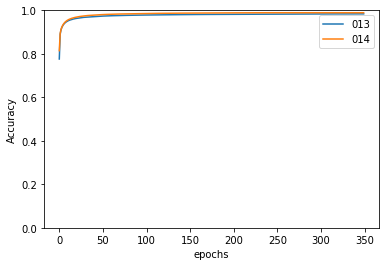

In [17]:
compareResults('005','013', metric1='acc', metric2='acc', saveFigName = 'testmynd', makeEqual = True)

test 70 epoch notch at 014


In [18]:
import math

# What data to use
tableBase = '4PpKk'
convertStates = False
fractionOfDataToUse = 1 # [0,1]

# Transfer Learning
loadWeights = False 
weightsSource = '014'

# Compare with other result during training
compareResultsDuringTraining = True
compareWith = '014'


# NN parameters
# filters = [8,16,16,32,32]    #016:0.913  10kpm 2048:30                  8192:23:38% 32768:17:52% 
# filters = [8,16,32,64,128]   #005:0.952  50kpm 2048:37s    4096:28:50% 
# filters = [8,32,64,128,256]  #013:0.968 188kpm 2048:50s    4096:40s:61%             32768:46s:80% 65536:42s:99% 
filters = [32,64,128,160,256]#014:0.974 388kpm 2048:3m:91% 
filterShape = [2,2,2,2,2]
batch_size = 2048
epochs = 100 

model, nnStr = createModel(filters, filterShape)
X_train, X_test, y_train, y_test = loadData()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 32, 7, 7)          544       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 31, 6, 64)         1856      
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 30, 5, 128)        32896     
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 29, 4, 160)        82080     
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 28, 3, 256)        164096    
_________________________________________________________________
flatten_10 (Flatten)         (None, 21504)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 107525    
Total para

OSError: Unable to open file (unable to open file: name = '4PpKk.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

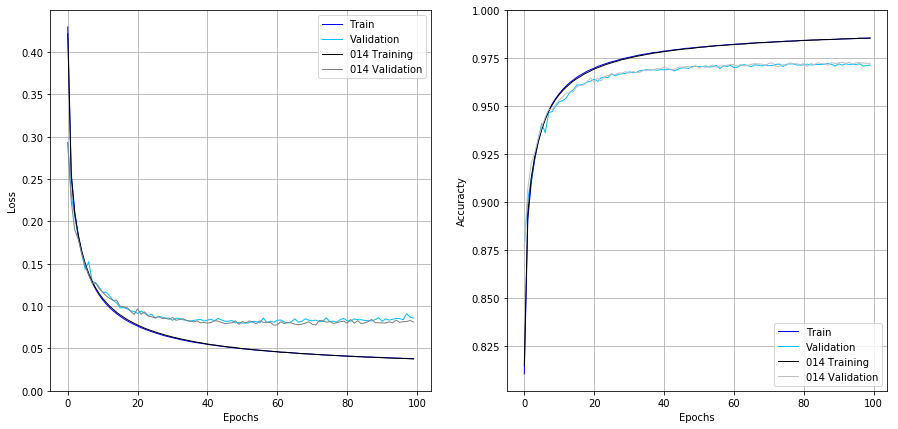

Train Accuracy of last epoch:  0.9854940951569019
Validation Accuracy of last epoch:  0.9715168853022483
Train Loss of last epoch:  0.037930240660752
Validation Loss of last epoch:  0.08590831578326323
2453910/2453910 [==============================] - 133s 54us/step
Evaluated test loss: 0.08590831612727692
Evaluated test accuracy: 0.9715168852973418
Save dir: Results/021
Creating save dir
Saving history...
Saving weights...
Saving figures...


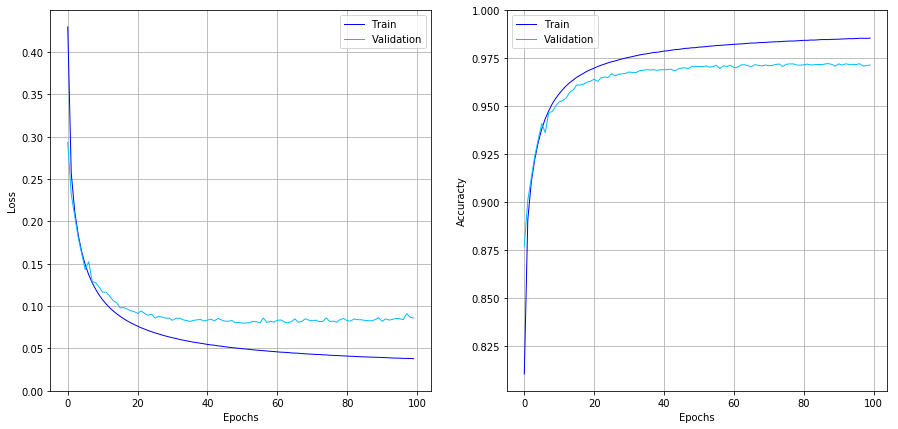

Saving summary...
All done!


In [16]:
fitHistory = trainModel()
score = calcScore()
saveTrainResults()